# Improving Starbucks Offer Targeting with Redemption Prediction

## 02. Exploratory Data Analysis

This is the second notebook out of 3 which details some of the preliminary relationships and trends observed in the data.

<b> Content </b>
- [0. Recap of Variables](#section0)
- [1. Overall Offer Redemption Success](#section1)
- [2. Offer Delivery Frequency & Schedule](#section2)
- [3. Offer Success by Customer Features](#section3)
- [4. Offer Success by Promotion Features](#section4)
- [5. Transaction Amount for Successful Redemption](#section5)
    - [5.1 Amount by Promotion Type](#section5.1)
    - [5.2 Amount by Promotion Type](#section5.2)
- [6. Overall Variable Correlations](#section6)

In [1]:
# Import numerical libraries
import numpy as np
import pandas as pd

# Import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 0. Recap of Variables<a class="anchor" id="section0"></a>

This data was already processed in Notebook *01.Data Preprocessing*.

- *person*: Alphanumeric identifier of a customer
- *offer_id*: Alphanumeric identifier of an offer
- *journey*: Alphanumeric identifier of an end-to-end offer lifecycle
- *days*: Days since data collection has commenced
- *offer received, viewed, completed*: 0 if True, 1 if False
- *gender*: Male (M), Female (F) or Others (O)
- *age*: Numeric value for age
- *reward*: The number of reward points (stars*) awarded for completion of an offer
- *difficulty*: Minimum spend required to complete offer
- *duration*: Days that offer is valid for
- *offer type*: Buy-one-get-one (bogo), informational or direct discount
- *channels*: Communication channels that offer was delivered over, split into dummy 
- *promo_name*: Promotion configuration identifier
- *amount*: Transaction amount
- *catcoding*: Combination of offer received-offer viewed-offer completed as per the table below
- *scenario_description*: User-friendly description of *catcoding* as per the table below

<img src = "./images/customerjourneywstatus.png" width="700"/>

In [2]:
# Import and view data
df = pd.read_csv('data/preprocessed_data.csv')
df.columns

Index(['person', 'offer_id', 'journey', 'days', 'offer received',
       'offer viewed', 'offer completed', 'gender', 'age', 'income',
       'member_duration', 'reward', 'difficulty', 'duration', 'offer_type',
       'channel_web', 'channel_mobile', 'channel_social', 'promo_name',
       'amount', 'catcoding', 'scenario_description'],
      dtype='object')

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
journey,49824.0,40406.259875,23361.120238,1.0,20222.75,40415.500,60613.25,80945.00
days,49824.0,15.701690,8.287848,0.0,8.25,17.250,22.50,29.75
offer received,49824.0,0.999699,0.017349,0.0,1.00,1.000,1.00,1.00
offer viewed,49824.0,0.682683,0.465437,0.0,0.00,1.000,1.00,1.00
offer completed,49824.0,0.602762,0.489331,0.0,0.00,1.000,1.00,1.00
age,49824.0,52.709598,16.029805,18.0,42.00,54.000,65.00,83.00
income,49824.0,65167.850835,21602.048072,30000.0,49000.00,63000.000,79000.00,120000.00
member_duration,49824.0,521.799514,421.462788,0.0,206.00,355.000,798.00,1823.00
reward,49824.0,5.248856,2.986725,2.0,3.00,5.000,5.00,10.00
difficulty,49824.0,9.640234,4.457990,5.0,7.00,10.000,10.00,20.00


In [4]:
# Set global formatting as we will be doing a lot of visualisations
# Visualize the data for key features 
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

palette = sns.color_palette("Set1")

# Set all floats to display only 2 decimal points
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Overall Offer Redemption Success<a class="anchor" id="section1"></a>

- <b>Success Rate</b>: Only about 42% of all promotions sent out are ultimately redeemed on purpose ("success").
- <b>Wastage</b>: 13% of customers do not even see the promotion and yet redeemed it ("failed, completed"), suggesting that the promotion was unnecessary in this case and value was lost as the customer would have purchased anyway and redeemed the promotion without being previously aware of it

In [5]:
# Compute class prior --> of all those who received an offer, what percentage saw and redeemed?
print("For all who received a promo, percentage of the action that followed:")
round(df['scenario_description'].value_counts()/df['scenario_description'].count()*100,1)

For all who received a promo, percentage of the action that followed:


success             42.00
failed, seen        26.30
failed, completed   18.30
failed, not seen    13.40
Name: scenario_description, dtype: float64

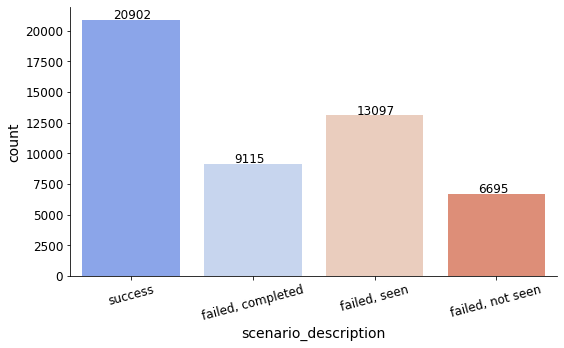

In [6]:
# Add categorisation order
sorter2 = ['success', 'failed, completed','failed, seen', 'failed, not seen']
df['scenario_description'] = df['scenario_description'].astype("category")
df['scenario_description'].cat.set_categories(sorter2, inplace=True)

# Visualise count of categories
fig = plt.figure(figsize=[8,5])
ax = sns.countplot(x = df['scenario_description'], palette = 'coolwarm')

for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+100))

sns.despine()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 2. Offer Delivery Frequency & Schedule<a class="anchor" id="section2"></a>

This shows the different promotions sent out across the entire 30 days.

- <b> Batch sending </b>: 6 spikes are observed, meaning the bulk of promotions are sent out on batches
- <b> Targeted offers </b>: It can be concluded that promotions are targeted as not all customers receive all promotions and at the same time
- <b> 4 offers per month </b>: Customers receive between 1 and 7 offers, with a 4 being the most frequent.

In this analysis, we do not go into recommending the optimal number of offers per month and continue to use the mode of 4 from here. In notebook 3, we focus on optimising the top 4 offers to be sent each month.

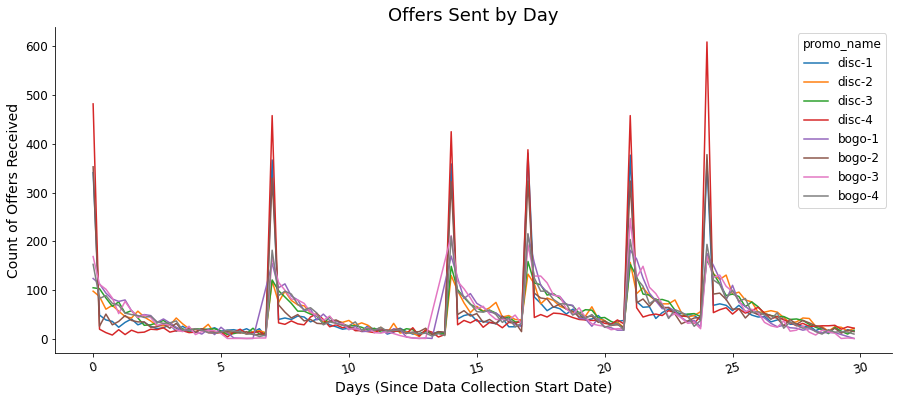

In [7]:
# Get count of offers sent to all customers by offer type
df_line = df[['days','promo_name', 'offer received']]
df_line = df_line.groupby(['days', 'promo_name']).agg({'offer received':'sum'})
df_line.reset_index(inplace = True)

# Overwrite categorisation order
df_line['promo_name'] = df_line['promo_name'].astype("category")
sorter3 = ['disc-1', 'disc-2','disc-3', 'disc-4', 'bogo-1', 'bogo-2', 'bogo-3', 'bogo-4']
df_line['promo_name'].cat.set_categories(sorter3, inplace=True)

# Visualize promotions received by time
fig = plt.figure(figsize=[15,6])
ax = sns.lineplot(data = df_line, 
                  x = 'days', 
                  y = 'offer received', 
                  hue = 'promo_name')
plt.xlabel('Days (Since Data Collection Start Date)')
plt.ylabel('Count of Offers Received')
plt.title('Offers Sent by Day', fontsize = 18)
plt.xticks(rotation=15)
sns.despine()

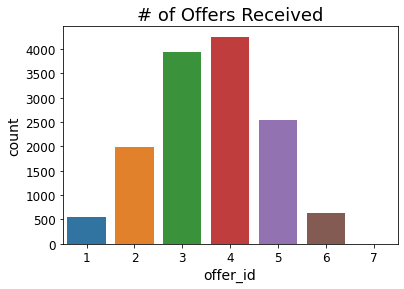

In [8]:
sns.countplot(df.groupby('person').count()['offer_id'])
plt.title('# of Offers Received', fontsize = 18)
plt.show()

## 3. Offer Success by Customer Features<a class="anchor" id="section3"></a>

- <b> Gender differences:</b> Offer redemption behaviour was visibly different based on gender as women generally were more likely than men to see and complete a promotion
- <b> Member duration differences:</b> Long-time members (~500 to 100 days) were more likely to see and complete offers, as were members in the 80,000 - 100,000 income range

There was no noticeable difference by income or age.

In [9]:
# Add a binary success / failure column
df['success'] = np.where(df["scenario_description"] == 'success',1,0)

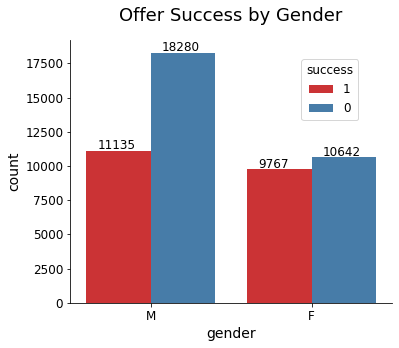

In [10]:
# Plotting differences by gender (discrete)
fig = plt.figure(figsize=[15,5])

features = ['gender']

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(1, 3, i+1)
    ax = sns.countplot(data=df,x=df.columns[loc], hue = 'success', hue_order = [1,0],
                      palette = sns.color_palette(palette, n_colors=2))
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    sns.despine()

for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.07, p.get_height()+100))

plt.title('Offer Success by Gender', fontsize = 18, y=1.05)
plt.tight_layout()
plt.show()

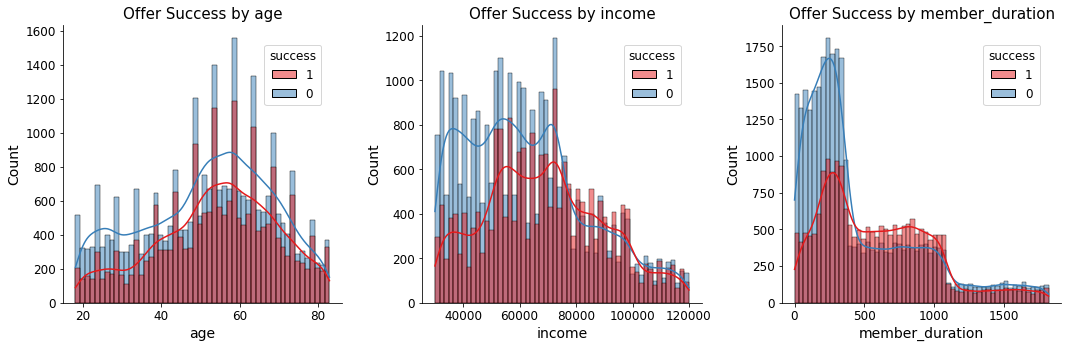

In [11]:
# Plotting differences by age, income and member duration (continuous)
fig = plt.figure(figsize=[15,5])

features = ['age', 'income', 'member_duration']

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(1, 3, i+1)
    ax = sns.histplot(data=df,x=df.columns[loc], hue = 'success', hue_order = [1,0],
                      kde = True, palette = sns.color_palette(palette, n_colors=2))
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    ax.set_title("Offer Success by {}".format(features[i]), fontsize = 15)
    sns.despine()

plt.tight_layout()
plt.show()

## 4. Offer Success by Promotion Features<a class="anchor" id="section4"></a>

- <b> Importance of Social Media: </b> If the promotion was not on social media (channel_social = 0), it is much less likely to be redeemed
- <b> Higher Difficulty, Less Redemption:</b> For difficulty, the higher minimum spend required, the less likely the promotion will be redeemed.

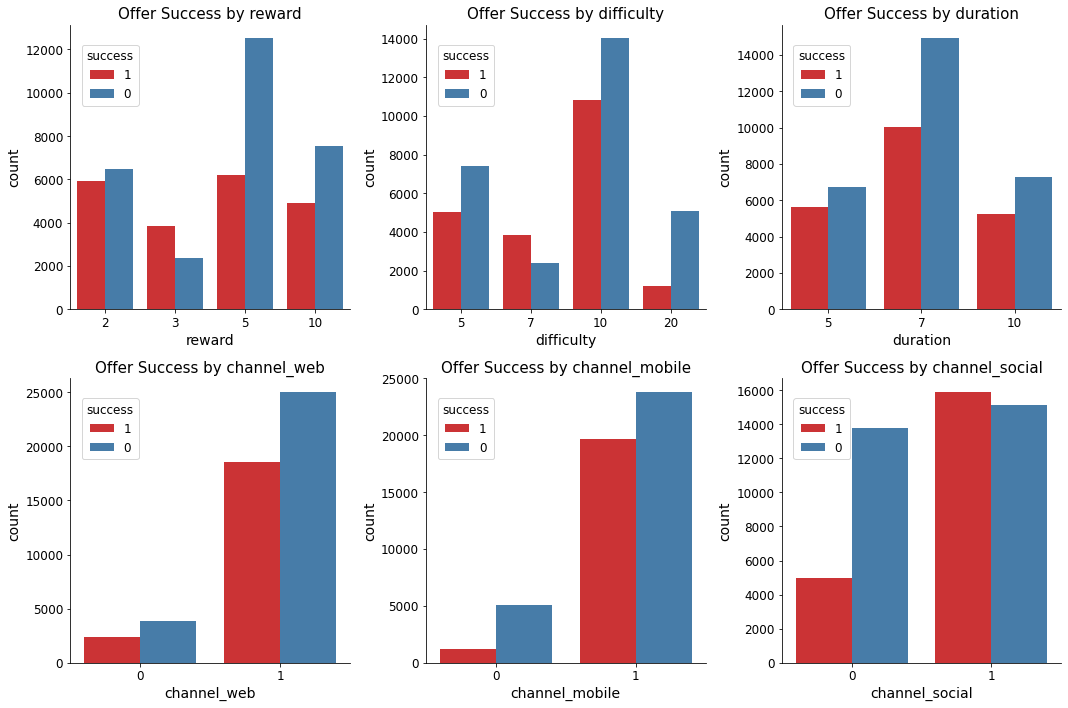

In [21]:
fig = plt.figure(figsize=[15,10])

features = ['reward', 'difficulty', 'duration', 'channel_web', 'channel_mobile', 'channel_social']

for i in range(len(features)):
    loc = df.columns.get_loc(features[i])
    fig.add_subplot(2, 3, i+1)
    ax = sns.countplot(data=df,x=df.columns[loc], hue = 'success', hue_order = [1,0], 
                       palette = sns.color_palette(palette, n_colors=2))
    ax.legend_.set_bbox_to_anchor((0.02, 0.95))
    ax.legend_._set_loc(2)
    ax.set_title("Offer Success by {}".format(features[i]), fontsize = 15)
    sns.despine()

plt.tight_layout()
plt.show()

## 5. Transaction Amount for Successful Redemption<a class="anchor" id="section5"></a>

### 5.1 Amount by Promotion Type<a class="anchor" id="section5.1"></a>

- <b>Spend generally exceeds min spend (difficulty) </b>: Spend by promotion varies based on the offer type, understandably so as the minimum spend requirements (difficulty) vary for each offer.
    - It is interesting to note that although minimum spend requirements for certain promotions are low (e.g. bogo-1 & bogo-2 have USD\\$5 minimum spends) the mean actual spend far exceeds it (i.e. USD\\$15.30 & USD\\$16.50 respectively). 
    - This suggests that offers in general do still deliver a certain transaction value beyond the bare minimum and that regression to find expected value is important and needed.

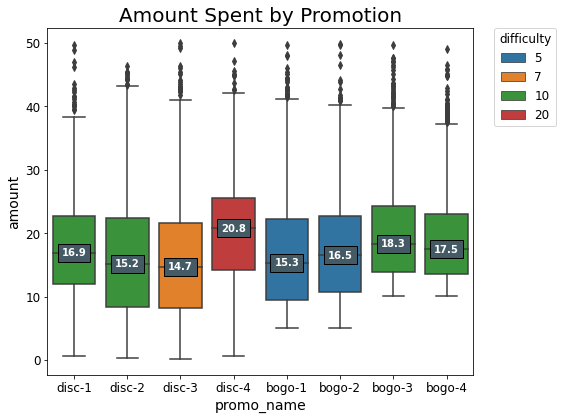

In [18]:
# Select only success scenarios
df_box = df[df['success']==1]

# Overwrite categorisation order
sorter4 = ['disc-1', 'disc-2','disc-3', 'disc-4', 'bogo-1', 'bogo-2', 'bogo-3', 'bogo-4']
df['promo_name'] = df['promo_name'].astype("category")
df_box['promo_name'].cat.set_categories(sorter4, inplace=True)

plt.figure(figsize=(8,6))

box_plot = sns.boxplot(x="promo_name", y="amount", data=df_box, hue = 'difficulty', dodge=False)

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold', 
            size=10, color='white',bbox=dict(facecolor='#445A64'))

plt.legend(title = 'difficulty', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Amount Spent by Promotion', fontsize = 20)

box_plot.figure.tight_layout()

### 5.2 Amount by Demographic<a class="anchor" id="section5.2"></a>

<b>Older</b> individuals as well as <b>high-income</b> individuals are expected to spend more. There is no noticeable trend by member duration.

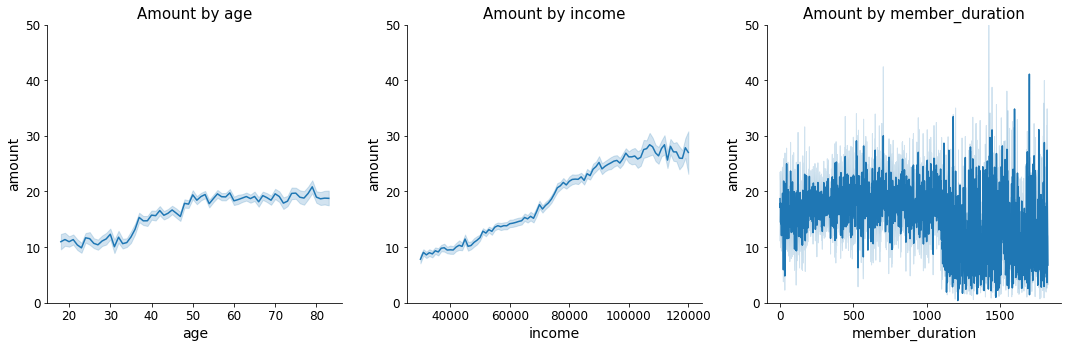

In [20]:
# Select only success scenarios
df_hist = df[df['success']==1]

fig = plt.figure(figsize=[15,5])

features = ['age', 'income', 'member_duration']

for i in range(len(features)):
    loc = df_hist.columns.get_loc(features[i])
    fig.add_subplot(1, 3, i+1)
    ax = sns.lineplot(data = df_hist,x=df_hist.columns[loc], 
                      y = df_hist['amount'] ,palette = sns.color_palette(palette))
    ax.set_title("Amount by {}".format(features[i]), fontsize = 15)
    ax.set_ylim([0, 50])
    sns.despine()


plt.tight_layout()
plt.show()

## 6. Overall Variable Correlations<a class="anchor" id="section6"></a>

The correlations below neatly summarize the EDA that has been done above.

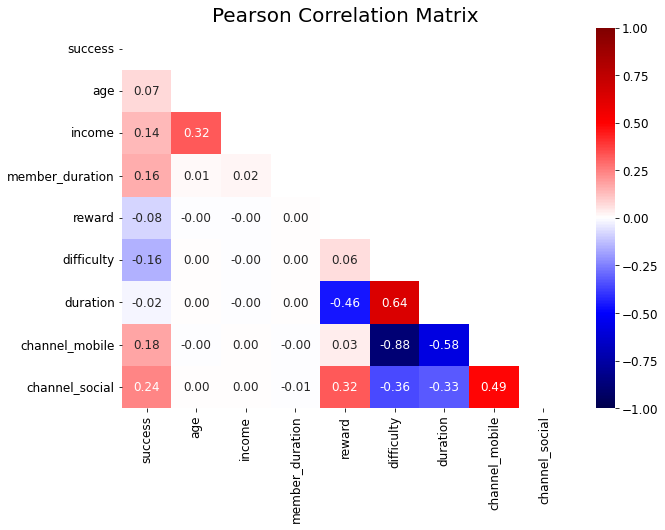

In [25]:
# Correlation matrix
# Pairwise correlation of columns
cols = df[['success', 'age', 'income','member_duration',
           'reward', 'difficulty', 'duration', 'channel_mobile', 'channel_social']]

plt.figure(figsize=(10,7))
corr_matrix = cols.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(data= corr_matrix, mask = mask, cmap='seismic', vmax = 1, vmin=-1, annot=True, fmt='0.2f')
plt.title('Pearson Correlation Matrix', fontsize = 20)
plt.show()